# Calculating solar spectrum from the NOAA database

Here, we create a NEMESIS solar file using the solar spectral irradiance from the [National Oceanic and Atmospheric Administration](https://www.ncei.noaa.gov/products/climate-data-records/solar-spectral-irradiance). This product covers a wide range of wavelengths and is widely used in climate models (0 to 200 $\mu$m). It is based on Version 1 of the NASA NOAA LASP (NNL) solar variability models. These models estimate changes in solar irradiance due to faculae and sunspots, as well as the F10.7 cm solar radio flux.

Here, we convert the solar irradiance from a given year into a solar file with the NEMESIS format.

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import archnemesis as ans

In [2]:
year = 2024   #From 1960 to 2373

## Reading the file

In [3]:
# Open the file
dataset = nc.Dataset('ssi_v03r00_yearly_s1610_e2023_c20240831.nc', "r")

# Check variables
print(dataset.variables.keys())

# Access a specific variable
wavelength = dataset.variables["wavelength"][:]  #nm
time = np.array(dataset.variables["time"][:]/365. + 1960.,dtype='int32')  #years since 1610-01-01
solar_irradiance = dataset.variables["SSI"][:]  #(ntime,nwave) W m-2 nm-1

# Close the dataset
dataset.close()

dict_keys(['SSI', 'wavelength', 'Wavelength_Band_Width', 'TSI', 'time', 'TSI_UNC', 'time_bnds', 'SSI_UNC'])


## Defining the Stellar class

In [4]:
Stellar = ans.Stellar_0()

Stellar.ISPACE = 1                 #Wavelength space
Stellar.NWAVE = len(wavelength)    #Number of spectral points
Stellar.WAVE = wavelength /1.0e3   #Wavelength array

Stellar.DIST = 1.0                 #Earth-Sun distance (since this is spectral irradiance at the Earth
Stellar.RADIUS = 6.955e5           #Radius of the Sun (km)

itime = np.where(time==year)[0][0]
Stellar.SOLFLUX = solar_irradiance[itime,:] * 1.0e3 * 1.0e-4    #Spectral irradiance at the Earth distance in W cm-2 um-1
Stellar.calc_solar_power()         #Calculate the solar power in W um-1

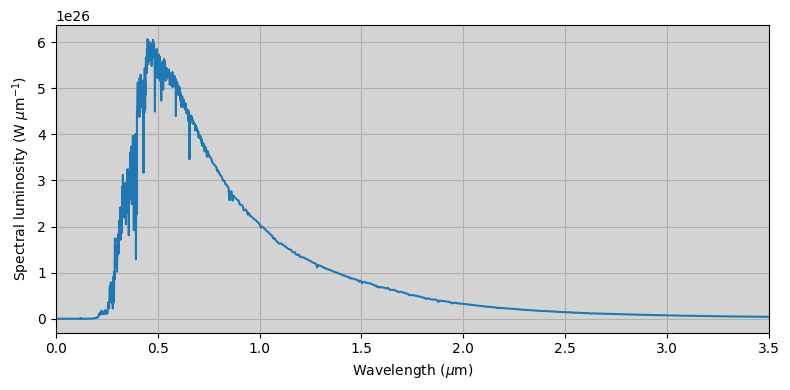

In [5]:
fig,ax1 = plt.subplots(1,1,figsize=(8,4))
ax1.plot(Stellar.WAVE,Stellar.SOLSPEC)
ax1.grid()
if Stellar.ISPACE==0:
    ax1.set_xlabel('Wavenumber (cm$^{-1}$)')
    ax1.set_ylabel('Spectral luminosity (W (cm$^{-1}$)$^{-1}$)')
elif Stellar.ISPACE==1:
    ax1.set_xlabel('Wavelength ($\mu$m)')
    ax1.set_ylabel('Spectral luminosity (W $\mu$m$^{-1}$)')
ax1.set_facecolor('lightgray')
ax1.set_xlim(0.,3.5)
plt.tight_layout()

## Writing NEMESIS solar file

In [6]:
#Writing the new stellar file
Stellar.write_solar_file('solar_noaa_wl_'+str(year)+'.txt')